# Notebook to understand Affine and Elastic Transformation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from copy import deepcopy
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from typing import Tuple

In [3]:
(height, width) = 250, 300
(box_height, box_width) = int(height) // 10, int(width) // 10
figsize = (6, 6)

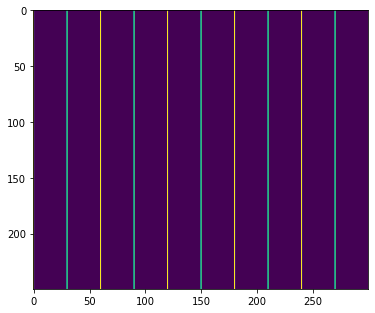

In [4]:
grid = np.zeros((height, width))
for x in range(0, width, box_width):
    cv2.line(img=grid, pt1=(x, 0), pt2=(x, height), color=(1,), thickness=1)

fig, ax = plt.subplots(figsize=figsize)
ax.imshow(grid)
plt.show()

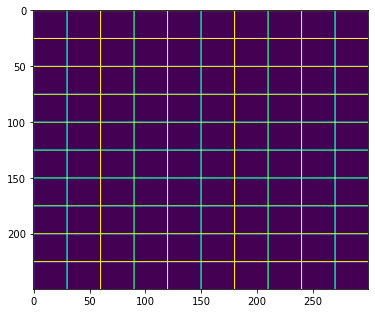

In [5]:
for y in range(0, height, box_height):
    cv2.line(img=grid, pt1=(0, y), pt2=(width, y), color=(1,))
        
fig, ax = plt.subplots(figsize=figsize)
ax.imshow(grid)
plt.show()

In [6]:
def make_grid(
    size: Tuple[int, int], 
    box_size: int) -> np.ndarray:
    
    grid = np.zeros(size)

    for x in range(0, width, box_width):
        cv2.line(img=grid, pt1=(x, 0), pt2=(x, height), color=(1,))
    
    for y in range(0, height, box_height):
        cv2.line(img=grid, pt1=(0, y), pt2=(width, y), color=(1,))
    
    return grid

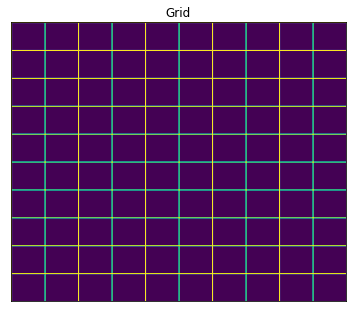

In [7]:
grid = make_grid(size=(height, width), box_size=(box_height, box_width))
fig, ax = plt.subplots(figsize=figsize)
ax.imshow(grid)
ax.set_title("Grid")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
# plt.tight_layout()
plt.show()

## Pick 3 points in image space

In [8]:
# find center of image

ref_ratio = 3
center_coord = np.float32([height, width]) // 2
print("Center coordinates in image space : ", center_coord)

ref_point = min((height, width)) // ref_ratio # reference point
print("Reference point in image space : ", ref_point)

Center coordinates in image space :  [125. 150.]
Reference point in image space :  83


Points in image space: (3, 2)


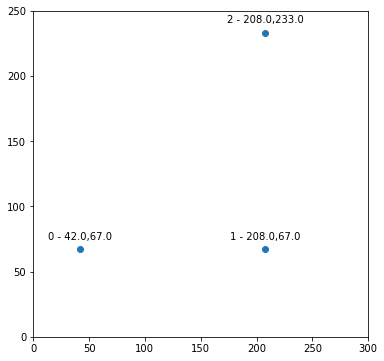

In [9]:
# Affine tranformation will generate transformation matrix when provided with 3 points in original image and 3 points in transformed image
pts_src = np.float32([
    center_coord - ref_point,
    center_coord + np.array([1., -1.]) * ref_point,
    center_coord + ref_point])

print(f"Points in image space: {pts_src.shape}")

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pts_src[:,0], pts_src[:,1])
ax.set_xlim(0, width)
ax.set_ylim(0, height)

for i, (x, y) in enumerate(pts_src):
    label = f"{i} - {x:.1f},{y:.1f}"

    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0, 10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

## Convert points in image space into points in transformed image space

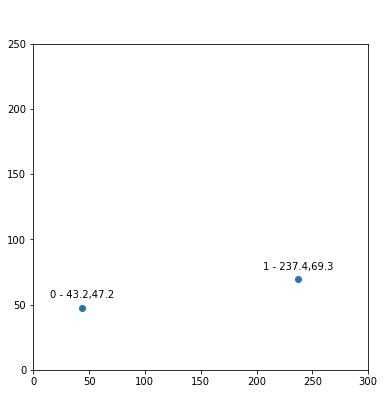

In [10]:
# # Random Affine
alpha_affine = min((height, width)) * 0.15
alpha_tranform = np.random.uniform(
    low=-alpha_affine,
    high=alpha_affine,
    size=pts_src.shape).astype(np.float32)

pts_dst = pts_src + alpha_tranform

fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pts_dst[:,0], pts_dst[:,1])
ax.set_xlim(0, width)
ax.set_ylim(0, height)

for i, (x, y) in enumerate(pts_dst):
    label = f"{i} - {x:.1f},{y:.1f}"

    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0, 10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

## Generate M (transformation matrix) to transform points from image space to transformed image space 

In [11]:
# get transformation matrix
M = cv2.getAffineTransform(pts_src, pts_dst)
print(f"Shape of M : {M.shape}")

Shape of M : (2, 3)


In [12]:
a = np.ones((3,3))
a[:,:2] = pts_src
a

array([[ 42.,  67.,   1.],
       [208.,  67.,   1.],
       [208., 233.,   1.]])

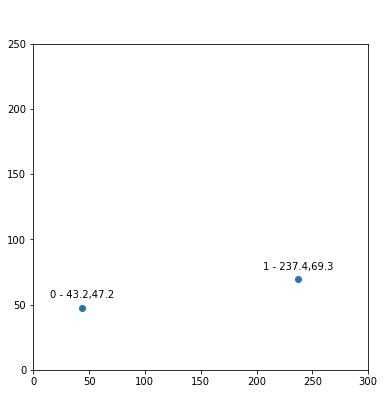

In [13]:
pts_recovered_dst = (M @ a.T).T
fig, ax = plt.subplots(figsize=figsize)
ax.scatter(pts_recovered_dst[:,0], pts_recovered_dst[:,1])
ax.set_xlim(0, width)
ax.set_ylim(0, height)

for i, (x, y) in enumerate(pts_recovered_dst):
    label = f"{i} - {x:.1f},{y:.1f}"

    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0, 10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

In [14]:
pts_dst, pts_recovered_dst

(array([[ 43.225586,  47.221947],
        [237.40668 ,  69.32488 ],
        [226.66281 , 264.26202 ]], dtype=float32),
 array([[ 43.22558594,  47.22194672],
        [237.40667725,  69.32488251],
        [226.66281128, 264.26202393]]))

## Affine Transformation 

https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/warp_affine/warp_affine.html

In [15]:
affine_trnsf_grid = cv2.warpAffine(
    src=grid,
    M=M,
    dsize=(width, height), 
    borderMode=cv2.BORDER_REFLECT_101)
print(f"\nElastic transformaed image shape : {affine_trnsf_grid.shape}")


Elastic transformaed image shape : (250, 300)


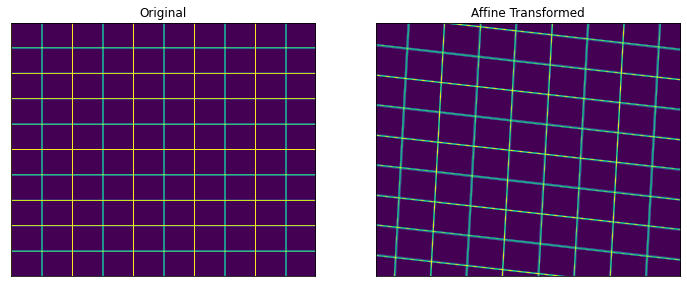

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

imgs = [grid, affine_trnsf_grid]
titles = ["Original", "Affine Transformed"]

for i, img in enumerate(imgs):
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])

plt.show()

## Steps for Elastic tranformation

In [17]:
layers = 2

In [18]:
affine_trnsf_grid = np.ones((height, width, layers)) * np.expand_dims(affine_trnsf_grid, axis=2)
affine_trnsf_grid.shape

(250, 300, 2)

In [19]:
np.random.RandomState().rand(5,5) * 2 - 1

array([[-0.34559008, -0.0325902 ,  0.53429754, -0.96577259, -0.68997072],
       [-0.63848474, -0.5273975 ,  0.92332267,  0.67642847, -0.27145839],
       [-0.25121756,  0.39469589,  0.82853882, -0.93041845,  0.49373359],
       [-0.96056363,  0.7489395 ,  0.33343167,  0.92281448,  0.46033303],
       [ 0.30255589,  0.63322661, -0.45087044, -0.28437851, -0.70089884]])

In [20]:
x, y, z = np.meshgrid(np.arange(width), np.arange(height), np.ones(layers))

In [21]:
x.shape

(250, 300, 2)

In [22]:
for i in range(layers): 
    print(i, x[:,:,i])

0 [[  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]
 ...
 [  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]]
1 [[  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]
 ...
 [  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]
 [  0   1   2 ... 297 298 299]]


In [23]:
y.shape

(250, 300, 2)

In [24]:
for i in range(layers):
    print(i, y[:,:,i])

0 [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [247 247 247 ... 247 247 247]
 [248 248 248 ... 248 248 248]
 [249 249 249 ... 249 249 249]]
1 [[  0   0   0 ...   0   0   0]
 [  1   1   1 ...   1   1   1]
 [  2   2   2 ...   2   2   2]
 ...
 [247 247 247 ... 247 247 247]
 [248 248 248 ... 248 248 248]
 [249 249 249 ... 249 249 249]]


In [25]:
z.shape

(250, 300, 2)

In [26]:
for i in range(layers):
    print(i, z[:,:,i])

0 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
1 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [27]:
random_state = np.random.RandomState()
sigma, alpha = width * .18, width * 2

dx = gaussian_filter(
    (random_state.rand(*(height, width, 1)) * 2 - 1), sigma=sigma, order=0, mode="reflect") * alpha
dx = np.ones((height, width, layers)) * dx
dy = gaussian_filter(
    (random_state.rand(*(height, width, 1)) * 2 - 1), sigma=sigma, order=0, mode="reflect") * alpha
dy = np.ones((height, width, layers)) * dy
dz = np.zeros_like(dx)

In [28]:
dx.shape, dy.shape, dz.shape

((250, 300, 2), (250, 300, 2), (250, 300, 2))

In [29]:
for i in range(layers):
    print(i, dx[:,:,i], "\n")

0 [[-4.69713066 -4.69584877 -4.69314309 ... -6.33340785 -6.33619144
  -6.33727064]
 [-4.69699243 -4.69571056 -4.69300499 ... -6.3324007  -6.33518404
  -6.33626316]
 [-4.69673261 -4.69545071 -4.69274523 ... -6.33040978 -6.33319263
  -6.33427159]
 ...
 [-1.88127615 -1.88090313 -1.88005158 ...  3.57888176  3.58110121
   3.58218386]
 [-1.8773634  -1.8769913  -1.87614157 ...  3.58050342  3.58272421
   3.58380752]
 [-1.87573314 -1.87536141 -1.87451241 ...  3.5815592   3.58378078
   3.58486449]] 

1 [[-4.69713066 -4.69584877 -4.69314309 ... -6.33340785 -6.33619144
  -6.33727064]
 [-4.69699243 -4.69571056 -4.69300499 ... -6.3324007  -6.33518404
  -6.33626316]
 [-4.69673261 -4.69545071 -4.69274523 ... -6.33040978 -6.33319263
  -6.33427159]
 ...
 [-1.88127615 -1.88090313 -1.88005158 ...  3.57888176  3.58110121
   3.58218386]
 [-1.8773634  -1.8769913  -1.87614157 ...  3.58050342  3.58272421
   3.58380752]
 [-1.87573314 -1.87536141 -1.87451241 ...  3.5815592   3.58378078
   3.58486449]] 



In [30]:
for i in range(layers):
    print(i, dy[:,:,i], "\n")

0 [[-1.56768467 -1.5687095  -1.57075967 ... -3.490675   -3.49171337
  -3.49246416]
 [-1.56761073 -1.56863544 -1.57068539 ... -3.48945103 -3.49048894
  -3.49123944]
 [-1.56729288 -1.56831742 -1.57036698 ... -3.48725466 -3.48829172
  -3.48904168]
 ...
 [ 5.03179835  5.03013708  5.02700148 ...  3.54738763  3.54735456
   3.54745319]
 [ 5.03482713  5.03316447  5.03002636 ...  3.54993965  3.54990649
   3.55000513]
 [ 5.03599074  5.03432749  5.03118835 ...  3.55122071  3.55118758
   3.55128627]] 

1 [[-1.56768467 -1.5687095  -1.57075967 ... -3.490675   -3.49171337
  -3.49246416]
 [-1.56761073 -1.56863544 -1.57068539 ... -3.48945103 -3.49048894
  -3.49123944]
 [-1.56729288 -1.56831742 -1.57036698 ... -3.48725466 -3.48829172
  -3.48904168]
 ...
 [ 5.03179835  5.03013708  5.02700148 ...  3.54738763  3.54735456
   3.54745319]
 [ 5.03482713  5.03316447  5.03002636 ...  3.54993965  3.54990649
   3.55000513]
 [ 5.03599074  5.03432749  5.03118835 ...  3.55122071  3.55118758
   3.55128627]] 



In [31]:
for i in range(layers):
    print(i, dz[:,:,i], "\n")

0 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

1 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 



In [32]:
(x + dx).shape, (y + dy).shape, (z + dz).shape

((250, 300, 2), (250, 300, 2), (250, 300, 2))

In [33]:
(x + dx).reshape(-1, 1).shape

(150000, 1)

In [34]:
coordinates = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))

In [35]:
elastic_trnsf_grid = map_coordinates(
    affine_trnsf_grid, coordinates, order=3, mode="reflect").reshape(affine_trnsf_grid.shape)
elastic_trnsf_grid.shape

(250, 300, 2)

In [36]:
for i in range(layers):
    print(i, elastic_trnsf_grid[:,:,i], "\n")

0 [[ 1.67414900e-11 -4.48648596e-12  1.19081551e-12 ...  9.70748081e-06
  -3.62889498e-05  1.35525158e-04]
 [ 1.72178148e-11 -4.61606545e-12  1.22622965e-12 ...  7.74383170e-06
  -2.89480573e-05  1.08108941e-04]
 [ 1.72209166e-11 -4.61687387e-12  1.22642378e-12 ...  5.93117427e-06
  -2.21767331e-05  8.28315902e-05]
 ...
 [ 1.08602845e-06  1.18511681e-06  1.06768342e-06 ...  7.02366568e-01
   2.54961231e-01 -5.54919283e-02]
 [-3.17253131e-07 -3.47476816e-07 -3.16343157e-07 ...  6.86616375e-01
   1.98848023e-01 -4.26209360e-02]
 [ 8.76950632e-08  9.61604003e-08  8.78521796e-08 ...  6.49888634e-01
   1.32088935e-01 -2.69971284e-02]] 

1 [[ 1.67414900e-11 -4.48648596e-12  1.19081551e-12 ...  9.70748081e-06
  -3.62889498e-05  1.35525158e-04]
 [ 1.72178148e-11 -4.61606545e-12  1.22622965e-12 ...  7.74383170e-06
  -2.89480573e-05  1.08108941e-04]
 [ 1.72209166e-11 -4.61687387e-12  1.22642378e-12 ...  5.93117427e-06
  -2.21767331e-05  8.28315902e-05]
 ...
 [ 1.08602845e-06  1.18511681e-06  1.0

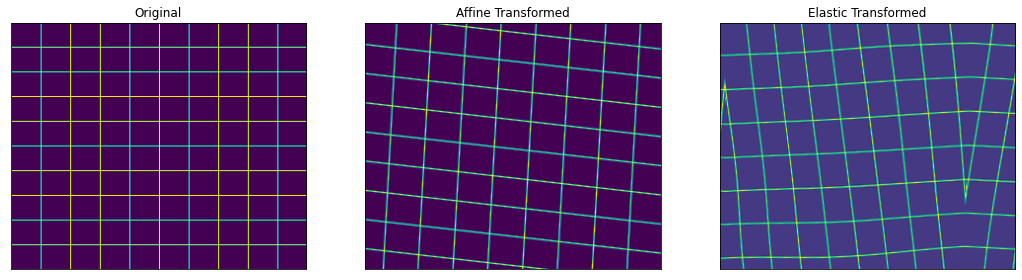

In [37]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

imgs = [grid, affine_trnsf_grid[:,:,0], elastic_trnsf_grid[:,:,0]]
titles = ["Original", "Affine Transformed", "Elastic Transformed"]

for i, img in enumerate(imgs):
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])

plt.show()

## Complete function to perform elastic transform

In [38]:
def custom_elastic_deform(
    img: np.ndarray,
    label: np.ndarray,
    alpha_affine: float,
    sigma: float,
    alpha: float,
    ref_ratio: float=3., 
    random_state: int=42) -> np.ndarray:
    
    """
    Parameters
    ----------
    img: numpy array of shape (H, W)
        H: height of image
        W: width of image
        
    label: numpy array of shape (H, W)
        H: height of image
        W: width of image
        
    
        Note: L is not channels, but layers
    """
    assert img.ndim == 2
    assert img.shape == label.shape
    
    height, width = img.shape
    center_coords = np.float32([height, width]) // 2
    ref_point = min([height, width]) // ref_ratio
    
    # fix 3 points in original image space
    pts_src = np.float32([
        center_coords - ref_point,
        center_coords + np.array([1., -1.]) * ref_point,
        center_coords + ref_point])
    
    # get 3 points in affine transformed image space
    alpha_affine = min([height, width]) * alpha_affine
    alpha_tranform = np.random.uniform(
        low=-alpha_affine,
        high=alpha_affine,
        size=pts_src.shape).astype(np.float32)
    pts_dst = pts_src + alpha_tranform
    
    # get affine transformation matrix to transform (x,y) points 
    # from original image space to affine transformed image space 
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
    M = cv2.getAffineTransform(pts_src, pts_dst)
    
    # perform affine transformation
    # https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/warp_affine/warp_affine.html
    img = cv2.warpAffine(
        src=img,
        M=M,
        dsize=(width, height), 
        borderMode=cv2.BORDER_REFLECT_101)
    
    label = cv2.warpAffine(
        src=label,
        M=M,
        dsize=(width, height), 
        borderMode=cv2.BORDER_REFLECT_101)
    
    x, y, z = np.meshgrid(np.arange(width), np.arange(height), np.ones(1))
    
    dx = gaussian_filter((np.random.rand(*(height, width, 1)) * 2 - 1), 
        sigma=sigma, 
        order=0, 
        mode="reflect") * alpha
    
    dy = gaussian_filter((np.random.rand(*(height, width, 1)) * 2 - 1),
        sigma=sigma, 
        order=0,
        mode="reflect") * alpha
    dz = np.zeros_like(dx)
    
    coordinates = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))
    
    img = map_coordinates(
        np.expand_dims(img, axis=2), 
        coordinates=coordinates,
        order=3, 
        mode="reflect").squeeze(axis=1).reshape(width, height).T
   
    label = map_coordinates(
        np.expand_dims(label, axis=2), 
        coordinates=coordinates,
        order=3, 
        mode="reflect").squeeze(axis=1).reshape(width, height).T
    
    return img, label

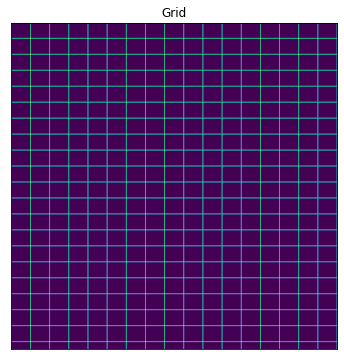

In [39]:
height, width = 512, 512
grid = make_grid(size=(height, width), box_size=(box_height, box_width))
fig, ax = plt.subplots(figsize=figsize)
ax.imshow(grid)
ax.set_title("Grid")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
# plt.tight_layout()
plt.show()

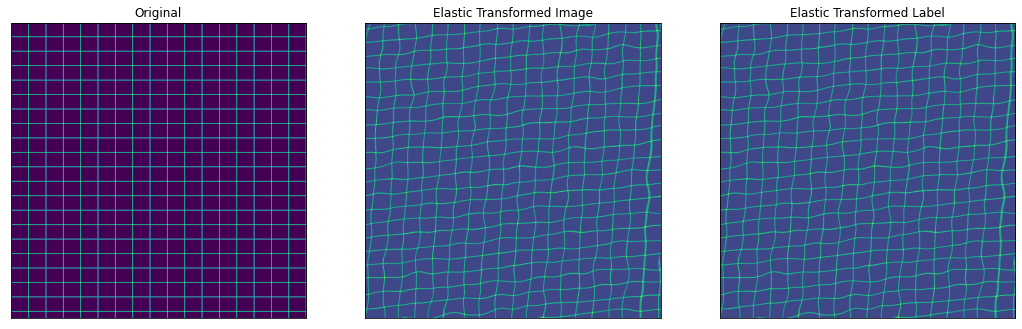

In [40]:
trsnf_img, trsnf_label = custom_elastic_deform(grid, grid, alpha_affine=.05, sigma=12, alpha=120)

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

imgs = [grid, trsnf_img, trsnf_label]
titles = ["Original", "Elastic Transformed Image", "Elastic Transformed Label"]

for i, img in enumerate(imgs):
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])

plt.show()

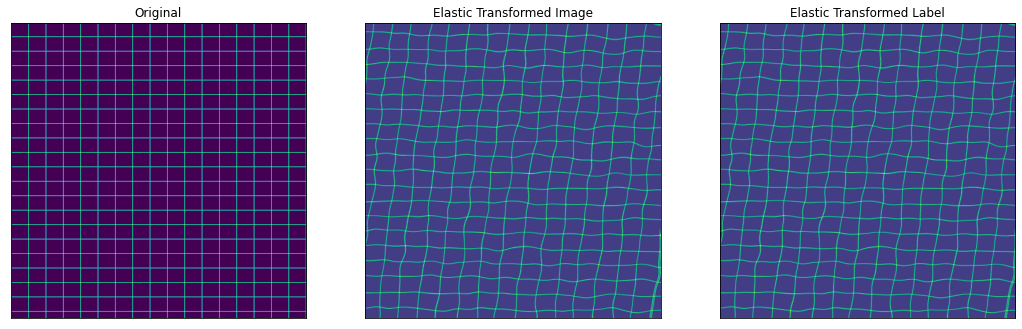

In [41]:
trsnf_img, trsnf_label = custom_elastic_deform(grid, grid, alpha_affine=.05, sigma=12, alpha=120)

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

imgs = [grid, trsnf_img, trsnf_label]
titles = ["Original", "Elastic Transformed Image", "Elastic Transformed Label"]

for i, img in enumerate(imgs):
    axes[i].imshow(img)
    axes[i].set_title(titles[i])
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])

plt.show()